In [1]:
from datetime import date, datetime, timedelta
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import sys
from datetime import datetime, timedelta
from covid19_DTM.data.mobility import * # contains all necessary functions
from covid19_DTM.visualization.output import *
from covid19_DTM.data.sciensano import get_sciensano_COVID19_data_spatial, get_sciensano_COVID19_data
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
start_date = datetime(2020, 1, 1, 0, 0)
end_date = datetime(2021, 7, 10, 0, 0)

In [3]:
####################################
## Compute economic shock vectors ##
####################################

from EPNM.data.utils import get_sector_labels
from EPNM.models.TDPF import household_demand_shock, labor_supply_shock, other_demand_shock
from EPNM.models.utils import initialize_model
params, model = initialize_model(shocks='alleman', prodfunc='half_critical')

# Compute aggregated household demand shock
time = pd.date_range(start=start_date, end=end_date, freq='D')
epsilon_D = []
for i,t in enumerate(time):
    epsilon_D.append(1-sum(params['c_0']/sum(params['c_0'])*household_demand_shock(t, {}, params['epsilon_D'], params['l1'], params['l2'], params['t_start_lockdown_1'], params['t_end_lockdown_1'], params['t_start_lockdown_2'], params['t_end_lockdown_2'], params['t_start_final_relax'], params['c_s'], params['ratio_c_s'], params['on_site'])))

# Compute aggregated exogenous demand shock
time = pd.date_range(start=start_date, end=end_date, freq='D')
epsilon_F = []
for i,t in enumerate(time):
    epsilon_F.append(1-sum(params['f_0']/sum(params['f_0'])\
                           *other_demand_shock(t, {}, params['epsilon_F'], params['l1'], params['l2'],
                                               params['t_start_lockdown_1'], params['t_end_lockdown_1'],
                                               params['t_start_lockdown_2'], params['t_end_lockdown_2'],
                                               params['t_start_final_relax'], params['ratio_c_s'],
                                               params['on_site'], params['t_end_inv_shock'],
                                               params['t_end_goods_shock'], params['t_end_services_shock'],
                                               params['f_gov'], params['f_inv'],
                                               params['f_exp_goods'], params['f_exp_services'],
                                               params['c_s'], params['f_s_inv'], params['f_s_exp_goods'],
                                               params['f_s_exp_services'])))
# Compute aggregated labor supply shock
time = pd.date_range(start=start_date, end=end_date, freq='D')
epsilon_S = []
for i,t in enumerate(time):
    epsilon_S.append(1-sum(params['l_0']/sum(params['l_0'])*labor_supply_shock(t, {}, params['epsilon_S'], params['l1'], params['l2'], params['t_start_lockdown_1'], params['t_end_lockdown_1'], params['t_start_lockdown_2'], params['t_end_lockdown_2'], params['l_s_1'], params['l_s_2'])))

In [4]:
#########################
## Key events pandemic ##
#########################

from covid19_DTM.visualization.utils import moving_avg
df_hosp, df_mort, df_cases, df_vacc = get_sciensano_COVID19_data(update=False)
sciensano_df_public = moving_avg(df_hosp[['H_in']].groupby('date').sum(), dropna=True)
sciensano_values_public = sciensano_df_public.values
sciensano_dates_public = sciensano_df_public.index + pd.Timedelta(hours=12)

t1 = pd.Timestamp(2020, 1, 10, 0, 0) # First death in China
t1_name = 'First death reported by Chinese officials'
t2 = pd.Timestamp(2020, 2, 3, 0, 0) # First case in BE
t2_name = 'First clinically diagnosed case in Belgium'
t3 = pd.Timestamp(2020, 3, 10, 0, 0) # First death in BE. Two more follow day after.
t3_name = 'First death in Belgium'
t4 = pd.Timestamp(2020, 3, 19, 0, 0) # Begin lockdown
t4_name = 'First Belgian lockdown'
t5 = pd.Timestamp(2020, 5, 4, 0, 0) #
t5_name = 'Lockdown exit: Phase I (industry, shops)'
t6 = pd.Timestamp(2020, 5, 18, 0, 0) #
t6_name = 'Lockdown exit: Phase II (schools)'
t7 = pd.Timestamp(2020, 6, 4, 0, 0) #
t7_name = 'Lockdown exit: Phase III (restaurants, bars)'
t8 = pd.Timestamp(2020, 7, 1, 0, 0)
t8_name = 'Lockdown exit: Phase IV (gatherings<15 ppl)'
t9 = pd.Timestamp(2020, 8, 1, 0, 0)
t9_name = 'Local lockdown in Antwerp province'
t10 = pd.Timestamp(2020, 9, 24, 0, 0)
t10_name = 'Releases of all remaining measures'
t11 = pd.Timestamp(2020, 10, 19, 0, 0)
t11_name = 'Second Belgian lockdown'
t12 = pd.Timestamp(2020, 11, 16, 0, 0)
t12_name = 'Re-opening primary/secondary schools'
t13 = pd.Timestamp(2020, 12, 27, 0, 0)
t13_name = 'Start of vaccination campaign'
t14 = pd.Timestamp(2021, 2, 4, 0, 0)
t14_name = '50% of cases caused by Alpha variant'
t15 = pd.Timestamp(2021, 4, 1, 0, 0)
t15_name = 'Vaccine coverage 13% of adult population'
t16 = pd.Timestamp(2021, 5, 1, 0, 0)
t16_name = 'Start of lockdown relaxation'

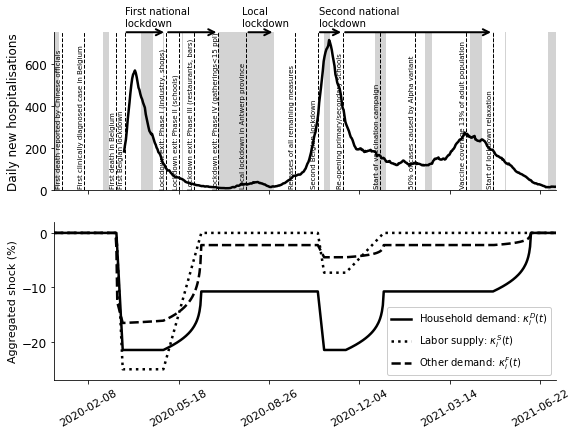

In [5]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(9,2*3.2))

#####################
# Pandemic timeline #
#####################

ax=axes[0]

show_lockdown = True
show_waves = False

ticklabelsize = 12
ax.set_xlim(start_date, end_date)
ylim=750
ax.set_ylim(0, ylim)
# Overlay hospitalisations
ax.grid(False)
ax.set_ylabel('Daily new hospitalisations', size=ticklabelsize)
plt.setp(ax.get_xticklabels(), fontsize=ticklabelsize)
ax.plot(sciensano_dates_public, sciensano_values_public, linewidth=2.5, color='black')
plt.setp(ax.get_yticklabels(), fontsize=ticklabelsize)

# Add arrows denoting lockdown periods
if show_lockdown:
    label_lockdown_size = 10
    label_lockdown_move_up = 30
    arrow_height = ylim
    # First lockdown
    ax.annotate(text='', xy=(t4, arrow_height), xytext=(t5,arrow_height), \
                arrowprops=dict(arrowstyle='<-',linewidth=2))
    label_lockdown1_move_right = 1 # days
    ax.text(t4 + pd.Timedelta(days=label_lockdown1_move_right), \
             ylim + label_lockdown_move_up, 'First national\nlockdown', size=label_lockdown_size)
    ax.annotate(text='', xy=(t5, arrow_height), xytext=(datetime(2020,7,1),arrow_height), \
                arrowprops=dict(arrowstyle='<-',linewidth=2))
    # Summer lockdown
    label_lockdown1_move_right = -5 # days
    ax.text(datetime(2020,8,1)+timedelta(days=label_lockdown1_move_right),
            ylim + label_lockdown_move_up, 'Local\nlockdown', size=label_lockdown_size)
    ax.annotate(text='', xy=(datetime(2020,8,1), arrow_height), xytext=(datetime(2020,9,1),arrow_height), \
                arrowprops=dict(arrowstyle='<-',linewidth=2))
    # Second lockdown
    label_lockdown1_move_right = 1 # days
    ax.text(t11 + pd.Timedelta(days=label_lockdown1_move_right), \
            ylim + label_lockdown_move_up, 'Second national\nlockdown', size=label_lockdown_size)
    ax.annotate(text='', xy=(t11, arrow_height), xytext=(t12,arrow_height), \
                arrowprops=dict(arrowstyle='<-',linewidth=2))
    # Lockdown light
    label_lockdown1_move_right = 35 # days
    ax.text(t12 + pd.Timedelta(days=label_lockdown1_move_right), \
            ylim + label_lockdown_move_up, '', size=label_lockdown_size)
    ax.annotate(text='', xy=(t12, arrow_height), xytext=(t16,arrow_height), \
                arrowprops=dict(arrowstyle='<-',linewidth=2))

# ax.annotate(text='', xy=(start_calibration_wave2,arrow_height), xytext=(end_calibration_wave2,arrow_height), \
#             arrowprops=dict(arrowstyle='<->'))
# label_cal2_move_right = 41 # days
# ax.text(start_calibration_wave2 + pd.Timedelta(days=label_cal2_move_right), \
#         ymax + label_cal_move_up, 'calibration wave 2', size=label_cal_size)

# Add vertically dashed lines
linestyle='--'
color='k'
linewidth=1
label_size = 7
label_height = 15
label_move_left = 7 #5.5 # days

# wave 1
ax.axvline(t1, linestyle=linestyle, color=color, linewidth=linewidth)
ax.text(t1-pd.Timedelta(days=label_move_left), label_height, t1_name, rotation=90, size=label_size)

ax.axvline(t2, linestyle=linestyle, color=color, linewidth=linewidth)
ax.text(t2-pd.Timedelta(days=label_move_left), label_height, t2_name, rotation=90, size=label_size)

ax.axvline(t3, linestyle=linestyle, color=color, linewidth=linewidth)
ax.text(t3-pd.Timedelta(days=label_move_left), label_height, t3_name, rotation=90, size=label_size)

ax.axvline(t4, linestyle=linestyle, color=color, linewidth=linewidth)
ax.text(t4-pd.Timedelta(days=label_move_left), label_height, t4_name, rotation=90, size=label_size)

ax.axvline(t5, linestyle=linestyle, color=color, linewidth=linewidth)
ax.text(t5-pd.Timedelta(days=label_move_left), label_height, t5_name, rotation=90, size=label_size)

ax.axvline(t6, linestyle=linestyle, color=color, linewidth=linewidth)
ax.text(t6-pd.Timedelta(days=label_move_left), label_height, t6_name, rotation=90, size=label_size)

ax.axvline(t7, linestyle=linestyle, color=color, linewidth=linewidth)
ax.text(t7-pd.Timedelta(days=label_move_left), label_height, t7_name, rotation=90, size=label_size)

ax.axvline(t8, linestyle=linestyle, color=color, linewidth=linewidth)
ax.text(t8-pd.Timedelta(days=label_move_left), label_height, t8_name, rotation=90, size=label_size)

ax.axvline(t9, linestyle=linestyle, color=color, linewidth=linewidth)
ax.text(t9-pd.Timedelta(days=label_move_left), label_height, t9_name, rotation=90, size=label_size)

ax.axvline(t10, linestyle=linestyle, color=color, linewidth=linewidth)
ax.text(t10-pd.Timedelta(days=label_move_left), label_height, t10_name, rotation=90, size=label_size)

ax.axvline(t11, linestyle=linestyle, color=color, linewidth=linewidth)
ax.text(t11-pd.Timedelta(days=label_move_left), label_height, t11_name, rotation=90, size=label_size)

ax.axvline(t12, linestyle=linestyle, color=color, linewidth=linewidth)
ax.text(t12-pd.Timedelta(days=label_move_left), label_height, t12_name, rotation=90, size=label_size)

ax.axvline(t13, linestyle=linestyle, color=color, linewidth=linewidth)
ax.text(t13-pd.Timedelta(days=label_move_left), label_height, t13_name, rotation=90, size=label_size)

ax.axvline(t14, linestyle=linestyle, color=color, linewidth=linewidth)
ax.text(t14-pd.Timedelta(days=label_move_left), label_height, t14_name, rotation=90, size=label_size)

ax.axvline(t15, linestyle=linestyle, color=color, linewidth=linewidth)
ax.text(t15-pd.Timedelta(days=label_move_left), label_height, t15_name, rotation=90, size=label_size)

ax.axvline(t16, linestyle=linestyle, color=color, linewidth=linewidth)
ax.text(t16-pd.Timedelta(days=label_move_left), label_height, t16_name, rotation=90, size=label_size)

###################
# Shocks timeline #
###################

ax=axes[1]

ax.plot(time, 100*np.array(epsilon_D)-100, linewidth=2.5, color='black', label='Household demand: $\\kappa_{i}^D(t)$')
ax.plot(time, 100*np.array(epsilon_S)-100, linewidth=2.5, color='black', linestyle='dotted', label='Labor supply: $\\kappa_{i}^S(t)$')
ax.plot(time, 100*np.array(epsilon_F)-100, linewidth=2.5, color='black', linestyle = 'dashed', label='Other demand: $\\kappa_{i}^F(t)$')
ax.legend(fontsize=10, loc=4, framealpha=1)
ax.set_ylim([-27,2])
ax.set_ylabel('Aggregated shock (%)', size=11)
plt.setp(ax.get_yticklabels(), fontsize=ticklabelsize)

######################
## Final formatting ##
######################

# Background coloring + no grid
week_color='white'
weekend_color='white'
vacation_color='lightgrey'

for ax in axes:
    ax.grid(False)
color_timeframes(start_date, end_date, ax=axes[0], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

# xticks
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
plt.xticks(rotation = 30, size=11)

plt.savefig('timeline.pdf', dpi=400, bbox_inches='tight')